In [1]:
import os
import json
import sys

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

sys.path.insert(1,'../optimization/')
from plant_optimization.notebook_tools import *

In [2]:
europe_grid = gpd.read_file('../../data/Countries_WGS84/processed/Europe_Evaluation_Grid.shp')
europe_grid.rename(columns={'grid_lat':'lat','grid_lon':'lon'},inplace=True)
europe_grid['sea_node'] = europe_grid.sea_node.astype(bool)
europe_borders = gpd.read_file('../../data/Countries_WGS84/processed/Europe_WGS84.shp')

EU_EFTA = europe_grid.country.unique()

results_path = os.path.join('../../results/plant_optimization/final_results') # Points to the location of the results csv files

specs = pd.read_excel('../../data/plant_assumptions.xlsx',sheet_name='data',index_col=0)
specs_names = specs.index

lc_path = '../../results/land_availability/CORINE'
sea_area_path = '../../results/land_availability/sea_area'
land_data = pd.DataFrame()
sea_data = pd.DataFrame()
for country in EU_EFTA:
    country_land_data = pd.read_csv(f'{lc_path}/{country}.csv')
    country_land_data['country'] = country

    land_data = land_data.append(country_land_data)
    try:
        sea_data = sea_data.append(pd.read_csv(f'{sea_area_path}/{country}.csv'))
    except FileNotFoundError:
        continue
land_data['sea_node'] = False
sea_data['sea_node'] = True

# Correct an error in which the Norway points are given NaN for the country name
land_data.loc[land_data.country.isna(),'country'] = 'Norway'
sea_data.loc[sea_data.country.isna(),'country'] = 'Norway'
sea_data.rename(columns={'avail_area_sqkm':'0'},inplace=True)
lc_data = pd.concat([land_data,sea_data]).sort_values(['country','lat','lon']).reset_index(drop=True)
# lc_data.crs = gpd.GeoDataFrame(lc_data,crs=europe_grid.crs)

corine_code = pd.read_excel('../../data/CORINE_legend.xlsx',usecols=[0,7])
corine_code = corine_code.rename(columns={'GRID_CODE':'code','LABEL3':'name'}).dropna()

results = {}
for year in [2020,2030,2040,2050]:
    df = pd.read_csv(os.path.join(results_path,f'{year}.csv'))
    df.drop(columns=['geometry'],inplace=True)
    gdf = gpd.GeoDataFrame(df.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

    spacing = gdf['sea_node'].apply(lambda x: {True:specs.at['wind_turbine_spacing_offshore',f'value_2020'],False:specs.at['wind_turbine_spacing_onshore',f'value_2020']}[x])
    gdf['turbine_area_sqkm'] = (gdf.rotor_diameter*spacing)**2*df.wind_turbines/1e6
    gdf['pv_area_sqkm'] = gdf.PV_capacity_MW*1e3/specs.at['PV_peak_per_area','value_2020']
    gdf['plant_area_sqkm'] = gdf['turbine_area_sqkm'] + gdf['pv_area_sqkm']

    results[year] = gdf

In [3]:
def calculate_production_potential(gdf,land_cover_types):
    land_cover_types = [str(int(x)) for x in land_cover_types]

    combined = gdf.merge(lc_data,on=['lat','lon','country','sea_node'],how='left')
    combined['avail_area_sqkm'] = combined[land_cover_types].sum(axis=1)
    combined = gpd.GeoDataFrame(combined, crs=gdf.crs)

    combined['plants'] = combined.avail_area_sqkm/combined.plant_area_sqkm
    combined['production_GWh'] = combined.plants * specs.at['required_fuel',f'value_2020']
    combined['production_liters'] = combined.production_GWh*3.6e12/specs.at['kerosene_LHV',f'value_2020']/0.8
    return combined

# Plot cost curve

IATA average jet fuel price for 2021: \$77.6/bbl [source](https://www.iata.org/en/publications/economics/fuel-monitor/)
<br> Average exchange rate 2021: 1.183 USD = 1 EUR [source](https://www.exchangerates.org.uk/EUR-USD-spot-exchange-rates-history-2021.html)
<br> IATA average jet fuel price for 2019: \$79.6/bbl [source](https://iata.org.xy2401.com/publications/economics/fuel-monitor/Pages/index.aspx.html)
<br> Average exchange rate 2019: 1.1199 USD = 1 EUR [source](https://www.exchangerates.org.uk/EUR-USD-spot-exchange-rates-history-2019.html)
<br> 1 US bbl oil = 158.99 L

In [4]:
exchange_rate_2019 = 1.1199 #USD to EUR
exchange_rate_2021 = 1.18 #USD to EUR
exchange_rate_2022 = 1.13 #USD to EUR
bbl_to_liter = 158.99 #US bbl oil to liters
fossil_price_2019 = 79.6/exchange_rate_2019/bbl_to_liter
fossil_price_2021 = 77.6/exchange_rate_2021/bbl_to_liter

EU32_fuel_demand_kg = 60e9 # 60 Mt jet fuel
kerosene_density = .820 #kg/l
EU32_fuel_demand_liters = EU32_fuel_demand_kg/kerosene_density

def calculate_cost_curve(df,max_lcof = 5):
    cost_curve = df.loc[df.LCOF_liter<=max_lcof].sort_values('LCOF_liter').reset_index()
    cost_curve['production_liters_cumsum'] = cost_curve.production_liters.cumsum()
    return cost_curve

In [5]:
plt.style.reload_library()
plt.style.use('EuroSAFs_pub')
%matplotlib inline

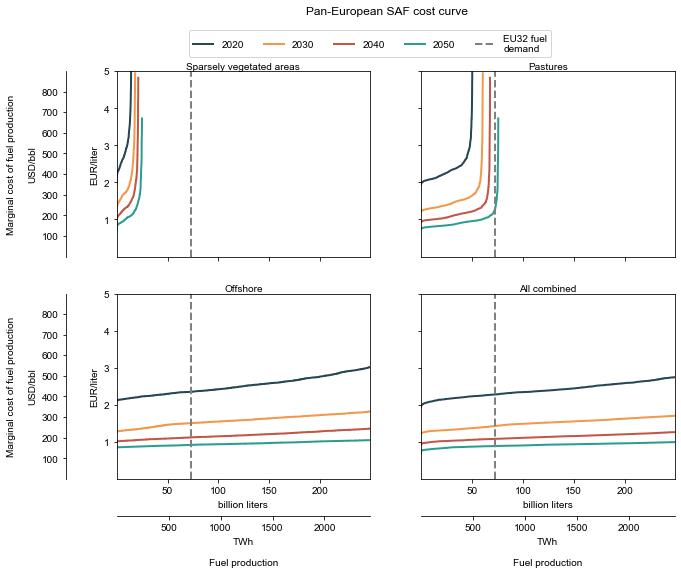

In [12]:
fig,axes = plt.subplots(nrows=2, ncols=2,figsize=(10,7.5))
axes = axes.reshape(1,-1)[0]
max_lcof=5

y_min = 1e-6 #0
y_max = max_lcof
x_min = 1e-6 #cost_curve.production_liters_cumsum.min()/1e9 # billion liters
x_max = 249 #325 # billion liters


scenarios = [[32],[18],[0],[0,18,32]]
titles = [
    'Sparsely vegetated areas',
    'Pastures',
    'Offshore',
    'All combined'
]

for j,(land_types,title) in enumerate(zip(scenarios,titles)):
    for i,year in enumerate([2020,2030,2040,2050]):
        production_potential = calculate_production_potential(results[year],land_types)
        cost_curve = calculate_cost_curve(production_potential)

        axes[j].plot(cost_curve.production_liters_cumsum/1e9,cost_curve.LCOF_liter, label=year)
    
    
       
    axes[j].axvline(x=EU32_fuel_demand_liters/1e9, color='grey', linestyle='--', label='EU32 fuel\ndemand')

    axes[j].set_title(title,pad=2)
    axes[j].set_ylim(y_min,y_max)
    axes[j].set_xlim(x_min,x_max)

    
    if j%2 == 0:
        axes[j].set_ylabel('EUR/liter', labelpad=5)
    
        yax2 = axes[j].secondary_yaxis(-0.2, functions=(lambda y: y*exchange_rate_2022*bbl_to_liter, lambda y: y/exchange_rate_2022/bbl_to_liter))
        yax2.set_ylabel('Marginal cost of fuel production\n\nUSD/bbl', labelpad=5)
        
    else:
        axes[j].tick_params(labelleft=False)  
        
    if j>1:
        axes[j].set_xlabel('billion liters', labelpad=5)

        xax2 = axes[j].secondary_xaxis(-0.2, functions=(lambda x: x*0.8*specs.at['kerosene_LHV','value_2020']/3.6e6, lambda x: x/0.8/specs.at['kerosene_LHV','value_2020']*3.6e6))
        xax2.set_xlabel('TWh\n\nFuel production', labelpad=5)
    else:
        axes[j].tick_params(labelbottom=False) 

fig.suptitle('Pan-European SAF cost curve',x=0.5,y=1.);
axes[0].legend(ncol=5, bbox_to_anchor=(1, 1.25), loc='upper center')
plt.savefig('../../gfx/pan-european_cost_curve_grid.png', bbox_inches='tight',dpi=400);

# Export data

In [7]:
scenarios = [[32],[18],[0],[0,18,32]]
titles = [
    'Sparsely vegetated areas',
    'Pastures',
    'Offshore',
    'All combined'
]

for j,(land_types,title) in enumerate(zip(scenarios,titles)):
    cost_curves_combined = pd.DataFrame()
    for i,year in enumerate([2020,2030,2040,2050]):
        production_potential = calculate_production_potential(results[year],land_types)
        cost_curve = calculate_cost_curve(production_potential, max_lcof=1e6)
        cost_curve = cost_curve[['LCOF_liter','production_liters','production_liters_cumsum']]
        cost_curve.rename(columns={x:x+f'_{year}' for x in cost_curve.columns},inplace=True)
        cost_curves_combined = pd.concat([cost_curves_combined,cost_curve],axis=1)
    cost_curves_combined.to_csv(os.path.join('..','..','results','plant_optimization','final_results','cost_curves',f'{title} cost curve.csv'))

# Auxiliary figures

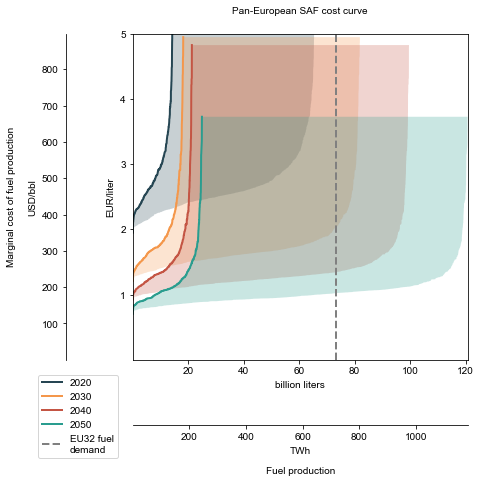

In [8]:
fig,axes = plt.subplots(figsize=(6,6))
max_lcof=5

for i,year in enumerate([2020,2030,2040,2050]):
    production_potential1 = calculate_production_potential(results[year],[32])
    cost_curve1 = calculate_cost_curve(production_potential1)
    
    axes.plot(cost_curve1.production_liters_cumsum/1e9,cost_curve1.LCOF_liter, label=year)
    
    land_production_potential = production_potential1.copy()
    land_production_potential.loc[production_potential1.sea_node,'production_liters'] = 0
    land_cost_curve = calculate_cost_curve(land_production_potential)
    
    production_potential2 = calculate_production_potential(results[year],[13,22,28,29,32])#[x for x in np.arange(1,51)])
    cost_curve2 = calculate_cost_curve(production_potential2)
    
    axes.fill_betweenx(land_cost_curve.LCOF_liter,land_cost_curve.production_liters_cumsum/1e9,cost_curve2.production_liters_cumsum/1e9,alpha=0.25)
    
    
    
axes.axvline(x=EU32_fuel_demand_liters/1e9, color='grey', linestyle='--', label='EU32 fuel\ndemand')

y_min = 1e-6 #0
y_max = max_lcof
x_min = 1e-6 #cost_curve.production_liters_cumsum.min()/1e9 # billion liters
x_max = cost_curve2.production_liters_cumsum.max()/1e9 # billion liters

axes.set_ylim(y_min,y_max)
axes.set_ylabel('EUR/liter', labelpad=5)

yax2 = axes.secondary_yaxis(-0.2, functions=(lambda y: y*exchange_rate_2022*bbl_to_liter, lambda y: y/exchange_rate_2022/bbl_to_liter))
yax2.set_ylabel('Marginal cost of fuel production\n\nUSD/bbl', labelpad=5)

axes.set_xlim(x_min,x_max)
axes.set_xlabel('billion liters', labelpad=5)


xax2 = axes.secondary_xaxis(-0.2, functions=(lambda x: x*0.8*specs.at['kerosene_LHV','value_2020']/3.6e6, lambda x: x/0.8/specs.at['kerosene_LHV','value_2020']*3.6e6))

xax2.set_xlabel('TWh\n\nFuel production', labelpad=5)

axes.set_title('Pan-European SAF cost curve');#,pad=75);
axes.legend(ncol=1, bbox_to_anchor=(-0.03, -0.03), loc='upper right')

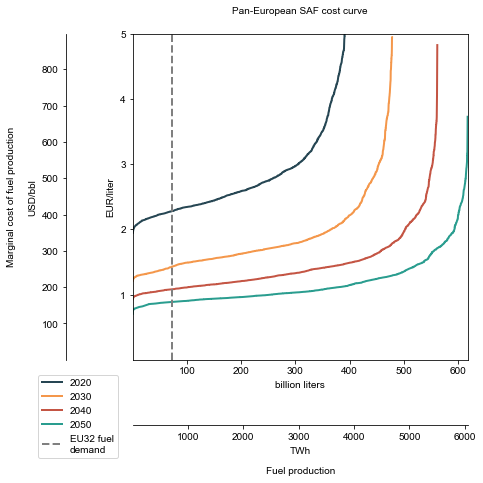

In [9]:
fig,axes = plt.subplots(figsize=(6,6))

for year in [2020,2030,2040,2050]:
    production_potential = calculate_production_potential(results[year],[0,18,32])
    cost_curve = calculate_cost_curve(production_potential)
    axes.plot(cost_curve.production_liters_cumsum/1e9,cost_curve.LCOF_liter, label=year)
    
axes.axvline(x=EU32_fuel_demand_liters/1e9, color='grey', linestyle='--', label='EU32 fuel\ndemand')

y_min = 1e-6 #0
y_max = max_lcof
x_min = 1e-6 #cost_curve.production_liters_cumsum.min()/1e9 # billion liters
x_max = cost_curve.production_liters_cumsum.max()/1e9 # billion liters

axes.set_ylim(y_min,y_max)
axes.set_ylabel('EUR/liter', labelpad=5)
yax2 = axes.secondary_yaxis(-0.2, functions=(lambda y: y*exchange_rate_2022*bbl_to_liter, lambda y: y/exchange_rate_2022/bbl_to_liter))
yax2.set_ylabel('Marginal cost of fuel production\n\nUSD/bbl', labelpad=5)

axes.set_xlim(x_min,x_max)
axes.set_xlabel('billion liters', labelpad=5)

xax2 = axes.secondary_xaxis(-0.2, functions=(lambda x: x*0.8*specs.at['kerosene_LHV','value_2020']/3.6e6, lambda x: x/0.8/specs.at['kerosene_LHV','value_2020']*3.6e6))

xax2.set_xlabel('TWh\n\nFuel production', labelpad=5)

axes.set_title('Pan-European SAF cost curve');#,pad=75);
axes.legend(ncol=1, bbox_to_anchor=(-0.03, -0.03), loc='upper right')